In [3]:
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.kalman import ExtendedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from numpy import sin,cos

def quaternion_multiply(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    return np.array([
        w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2,
        w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2,
        w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2,
        w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2
    ])

def normalize_quaternion(q):
    """ Ensures quaternion remains unit-length """
    return q / np.linalg.norm(q)

def quaternion_conjugate(q):
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

def rotate_vector_by_quaternion(v, q):
    v_quat = np.array([0.0, *v])
    q_conj = quaternion_conjugate(q)
    v_rotated = quaternion_multiply(quaternion_multiply(q, v_quat), q_conj)
    return v_rotated[1:]  # Extract vector part

class IMUSim:
    
    def __init__(self, dt, mag, accel, gyro, quat):
        self.mag = mag
        self.accel = accel
        self.gyro = gyro
        self.quat = quat
        self.dt = dt
        self.time = 0
        self.acceleration =np.array([[0,0,0],    # Velocity
                [0,0,0]])   # Acceleration

    def update(self, mag, accel, gyro):
        self.mag = mag
        self.accel = accel
        self.gyro = gyro
        self.integrate_angle()
        
    def integrate_angle(self):
        
        theta = np.linalg.norm(self.gyro) * self.dt
        print(theta)
        v = self.gyro/ np.linalg.norm(self.gyro)
        qChange = (cos(theta/2),v[0] * sin(theta/2), v[1] * sin(theta/2), v[2] * sin(theta/2))
        self.quat = quaternion_multiply(qChange, self.quat)  
        self.quat = normalize_quaternion(self.quat)  # Ensure unit quaternion
        


# many units (deg or rad dependent on gyro) around
# v = omega / ( ||omega|| ); // normalized orientation of angular velocity vector
# Thus, we can construct the rotation quaternion as:
# Q.update = (cos(theta/2),v_x * sin(theta/2), v_y * sin(theta/2), v_z * sin(theta/2));
# All that is left now is to rotate our current rotation by Q.update. This is trivial:
# Q.new = multiply_quaternions(Q.update,Q.new); 
# //note that Q.update * Q.new != Q.new * Q.update for quaternions



f = KalmanFilter (dim_x=3, dim_z=3)

f.x = np.array([[0],[0],[0],    # Velocity X,Y,Z
                [0],[0],[0]])   # Acceleration X,Y,Z

f.Q = Q_discrete_white_noise(dim=2, dt=0.1, var=0.13)


Rotated Vector: [-1.3  1.1  0.1]


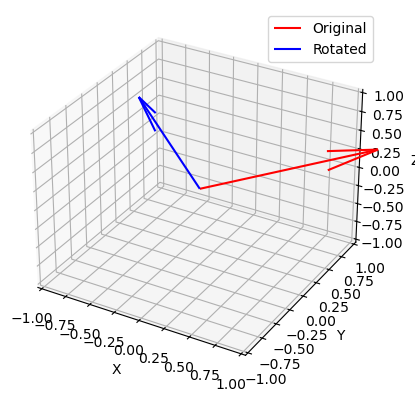

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



def plot_vectors(original, rotated):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Origin
    ax.quiver(0, 0, 0, original[0], original[1], original[2], color='r', label='Original')
    ax.quiver(0, 0, 0, rotated[0], rotated[1], rotated[2], color='b', label='Rotated')
    
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.show()

# Example usage:
v = np.array([1.1, 1.3, 0.1])  # Example vector
q = np.array([np.cos(np.pi/4), 0, 0, np.sin(np.pi/4)])  # 90-degree rotation around Z-axis
rotated_v = rotate_vector_by_quaternion(v, q)
print("Rotated Vector:", rotated_v)

plot_vectors(v, rotated_v)


In [5]:
def test_gyroscope_integration():
    # Initialize IMU simulation with arbitrary values
    dt = 0.1  # Time step
    mag = np.array([1, 0, 0])
    accel = np.array([0, 0, -9.81])
    gyro = np.array([0, 0, np.pi/4])  # Rotating around Z-axis at 45 degrees per second
    quat = np.array([1, 0, 0, 0])  # Initial quaternion (no rotation)
    
    imu = IMUSim(dt, mag, accel, gyro, quat)
    
    # Simulate a few time steps
    for _ in range(10):
        imu.update(mag, accel, gyro)
        print(f"Updated Quaternion: {imu.quat}")
    
    # Check if the quaternion is updating (not staying constant)
    assert not np.allclose(imu.quat, np.array([1, 0, 0, 0])), "Quaternion did not update!"
    print("Test passed: Gyroscope integration is working.")

# Run the test
test_gyroscope_integration()


0.07853981633974483
Updated Quaternion: [0.99922904 0.         0.         0.03925982]
0.07853981633974483
Updated Quaternion: [0.99691733 0.         0.         0.0784591 ]
0.07853981633974483
Updated Quaternion: [0.99306846 0.         0.         0.1175374 ]
0.07853981633974483
Updated Quaternion: [0.98768834 0.         0.         0.15643447]
0.07853981633974483
Updated Quaternion: [0.98078528 0.         0.         0.19509032]
0.07853981633974483
Updated Quaternion: [0.97236992 0.         0.         0.23344536]
0.07853981633974483
Updated Quaternion: [0.96245524 0.         0.         0.27144045]
0.07853981633974483
Updated Quaternion: [0.95105652 0.         0.         0.30901699]
0.07853981633974483
Updated Quaternion: [0.93819134 0.         0.         0.34611706]
0.07853981633974483
Updated Quaternion: [0.92387953 0.         0.         0.38268343]
Test passed: Gyroscope integration is working.


In [8]:
import numpy as np
from filterpy.kalman import ExtendedKalmanFilter



def predict(gyro, accel):
    
    # Extract state values
    velocity = ekf.x[3:6]
    quaternion = ekf.x[6:10]
    acc_bias = ekf.x[10:13]
    gyro_bias = ekf.x[13:16]

    # Bias-corrected measurements
    corrected_accel = accel - acc_bias
    corrected_gyro = gyro - gyro_bias

    # Update velocity and position
    ekf.x[3:6] += corrected_accel * dt  # v = v + (a - b_a) * dt
    ekf.x[0:3] += velocity * dt + 0.5 * corrected_accel * dt**2  # p = p + v*dt + 1/2 * a * dt^2

    # Update quaternion using gyro (integrate rotation)
    omega_norm = np.linalg.norm(corrected_gyro)
    if omega_norm > 1e-6:  # Avoid divide-by-zero
        axis = corrected_gyro / omega_norm
        theta = omega_norm * dt
        delta_q = np.array([np.cos(theta/2), *(np.sin(theta/2) * axis)])
        ekf.x[6:10] = normalize_quaternion(quaternion_multiply(delta_q, quaternion))
    
def measurement_function(x):
    velocity = x[3:6]
    acc_bias = x[10:13]
    gyro_bias = x[13:16]
    
    # Measurement vector: [velocity, raw_accel - bias, raw_gyro - bias]
    return np.hstack((velocity, -acc_bias, -gyro_bias))    

def update(accel, gyro):

    # Create measurement vector (raw accelerometer & gyro data)
    z = np.hstack((ekf.x[3:6], accel, gyro))  # [velocity, accel, gyro]

    # Compute Jacobian numerically
    HJacobian = np.eye(9, 19)  # Approximate H as identity

    # Update EKF
    ekf.update(z, HJacobian, measurement_function)



dt = 0.1  # Time step

ekf = ExtendedKalmanFilter(dim_x=19, dim_z=9)  # 16 state variables, 9 measurements
ZUPT = False

# Initial state
ekf.x = np.array([0, 0, 0,   # Position
                  0, 0, 0,   # Velocity
                  1, 0, 0, 0, # Unit quaternion (no rotation)
                  0, 0, 0, # Accelerometer Bias
                  0, 0, 0, # Magnatomter bias
                  0, 0, 0])  # Gyro Bias 

# Initial covariance
ekf.P = np.eye(19) * 1e-2  # Small initial uncertainty

# Process noise 
ekf.Q = np.eye(19) * 0.01  

# Measurement noise 
ekf.R = np.eye(9) * 0.1  

# State transition matrix 
ekf.F = np.eye(19)  

# Example of running the filter with dummy data
gyro = np.array([0.01, 0.02, 0.03])  # Gyroscope readings
accel = np.array([0.1, 0.2, 0.3])   # Accelerometer readings
accel = np.array([0.1, 0.2, 0.3])   # Accelerometer readings

# Prediction step
predict(gyro, accel)

# Update step
update(accel, gyro)

# Output the updated state
#print(ekf.x)

TypeError: 'numpy.ndarray' object is not callable